In [0]:
!pip install pyclipper

     |████████████████████████████████| 133kB 2.8MB/s 


coordinates = [32, 368, 215, 203, 86.64933050165546]
Best Area = 121068.11


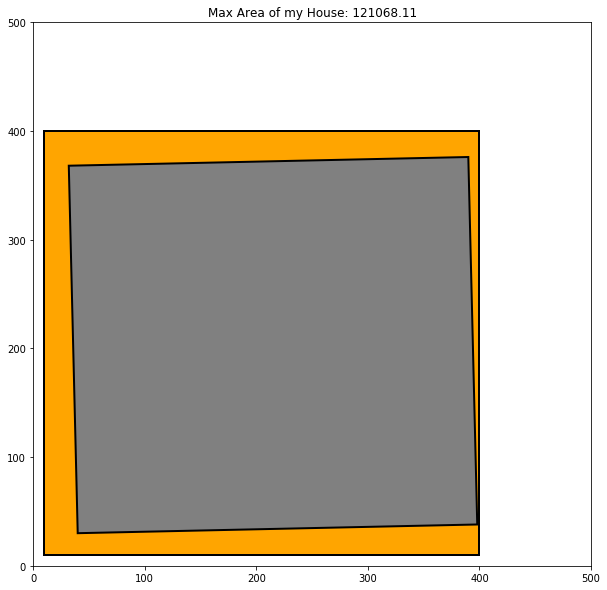

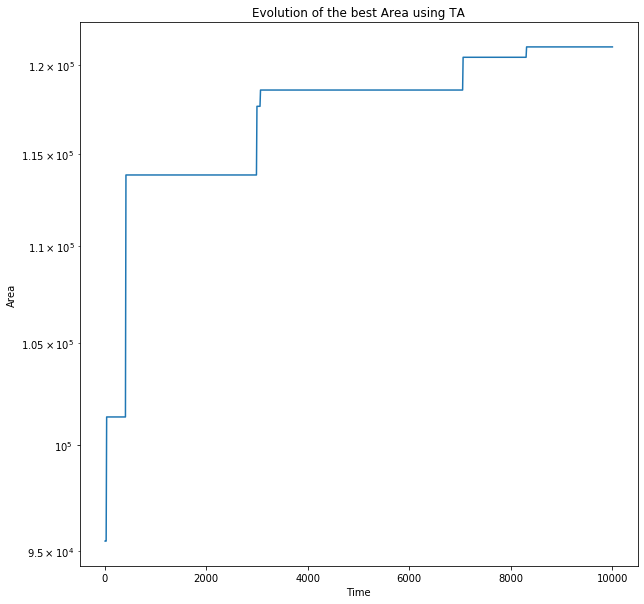

In [0]:
# -*- coding: Latin-1 -*-
# program that solves the traveling salesman problem (TSP)
# by the taboo search algorithm
# Dominique Lefebvre for TangenteX.com
# Peio Loubiere & Rachid Chelouah for EISTI
# September 2017
from scipy import *
from math import *
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sys
import pyclipper
from functools import *
import numpy as np
import random
# Instance of the problem

# Visualization of the plot
fig1 = plt.figure(1,figsize=(10,10))
canv = fig1.add_subplot(1,1,1)
canv.set_xlim(0,500)
canv.set_ylim(0,500)

# ***************** Paramètres du problème ******************
# Différent types of plots : 
polygon = ((10,10),(10,400),(400,400),(400,10)) 
# polygon = ((10,10),(10,300),(250,300),(350,130),(200,10)) 
# polygon = ((50,150),(200,50),(350,150),(350,300),(250,300),(200,250),(150,350),(100,250),(100,200))
#polygon = ((50,50),(50,400),(220,310),(220,170),(330,170),(330,480),(450,480),(450,50))

# ***********************************************************

# Transforms the polygon into a list for display.
def poly2list(polygon):
	polygonfig = list(polygon)
	polygonfig.append(polygonfig[0])
	return polygonfig

# Draw Constant polygon 
polygonfig = poly2list(polygon)

# Display visualization
def draw(polyfig,rectfig):
	global canv, codes
	canv.clear()
	canv.set_xlim(0,500)
	canv.set_ylim(0,500)
	# polygon figure
	codes = [Path.MOVETO]
	for i in range(len(polyfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(polyfig, codes)
	patch = patches.PathPatch(path, facecolor='orange', lw=2)
	canv.add_patch(patch)

	# rectangle figure
	codes = [Path.MOVETO]
	for i in range(len(rectfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(rectfig, codes)
	patch = patches.PathPatch(path, facecolor='grey', lw=2)
	canv.add_patch(patch)

	# Title(Area of Rectangle)

	plt.title("Max Area of my House: {}".format(round(area(rectfig[:-1]),2)))
	plt.draw()
	plt.pause(0.1)

# Figure of graphs of:
#   - all the energy of the retained fluctuations 
#   - The best energy
#   - temperature decrease
def drawStats(Htemps, Hbest):
	# afFILEhage des courbes d'evolution
	fig = plt.figure(2,figsize=(10,10))
	#add_subplot(1,1,1)
	plt.semilogy(Htemps, Hbest)
	plt.title('Evolution of the best Area using TA')
	plt.xlabel('Time')
	plt.ylabel('Area')
	#legend(mains, title='Optimization functions')
	#plt.tight_layout()
	plt.show()
	#plt.savefig('H:/Desktop/land1.png')
	
#display the best results
def dispRes(bplot,barea):
	print("coordinates = {}".format(bplot))
	#print("rectangle coordinate = {}".format(pos2rect(best['pos'])))
	print("Best Area = {}".format(barea))	

	
# Collect the boundaries of the bounding box around the parcel
def getbounds(polygon):
	lpoly = list(polygon) #tansformation into list for use with reduce function
	#return reduce(lambda (xmin,xmax,ymin,ymax),(xe,ye): (min(xe,xmin),max(xe,xmax),min(ye,ymin),max(ye,ymax)),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
	return reduce(lambda acc,e: (min(e[0],acc[0]),max(e[0],acc[1]),min(e[1],acc[2]),max(e[1],acc[3])),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
# ###################################################################################################################################################################################################################################
# Transformation of a solution of the pb (center / corner / angle) in rectangle for clipping
# Returns a rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
def pos2rect(pos):
	# coin : point A
	xa, ya = pos[0], pos[1]
	# centre du rectangle : point O
	xo, yo = pos[2], pos[3]
	# angle  AÔD
	angle = pos[4]

	# point D : centre for rotation O, at the Angle alpha
	alpha = pi * angle / 180 # degre en radian
	xd = cos(alpha)*(xa-xo) - sin(alpha)*(ya-yo) + xo 
	yd = sin(alpha)*(xa-xo) + cos(alpha)*(ya-yo) + yo
	# point C : symétrique de A, de centre O
	xc, yc = 2*xo - xa, 2*yo - ya 
	# point B : symétrique de D, de centre O
	xb, yb = 2*xo - xd, 2*yo - yd

	# round for clipping
	return ((round(xa),round(ya)),(round(xb),round(yb)),(round(xc),round(yc)),(round(xd),round(yd)))

	
# Distance between 2 points (x1,y1), (x2,y2)
def distance(p1,p2):
	return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Area of Rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
# = distance AB * distance BC
def area(pos):
	edge1=(pos[0],pos[1])
	edge2=(pos[1],pos[2])
	#print(pos[0],pos[1],pos[2],pos[3])
	#print(distance(p1[0],p1[1])* distance(p2[0],p2[1]))
	return round(distance(edge1[0],edge1[1])* distance(edge2[0],edge2[1]),2)
	
#def area ((pa, pb, pc, pd)):
# return distance (pa, pb) * distance (pb, pc)

# Clipping
# Predicate that verifies that the rectangle is in the polygon
# Test if
# - there is an intersection (! = []) between the figures and
# - the two lists are the same size and
# - all the points of the rectangle belong to the result of the clipping
# If error (~ flat angle), returns false

def verifyconstraint(rect, polygon):
	try:
		# Config
		pc = pyclipper.Pyclipper()
		pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
		pc.AddPath(rect, pyclipper.PT_CLIP, True)
		# Clipping
		clip = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
		#all(iterable) return True if all elements of the iterable are true (or if the iterable is empty)		
		return (clip!=[]) and (len(clip[0])==len(rect)) and all(list(map(lambda e:list(e) in clip[0], rect)))
	except pyclipper.ClipperException:
		# print rect
		return False


def initUn(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 90.00
	boolOK = False
	pos = []
	#print(pos)
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		#print(rect)
		#print('*************')
		#print(pos)
		#print(area(pos2rect(pos)))
		# calcul du clipping
		boolOK = verifyconstraint(rect,polygon)
	#print(pos2rect(pos))
	#print(rect)
	#print(pos)
	#print(area(pos2rect(pos)))
	ev = area(pos2rect(pos))
	#print(ev)
	return {'pos':pos, 'area':ev}

# for neighbours use initdeux
def initdeux(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 89.99
	boolOK = False
	pos = []
	#print(pos)
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		boolOK = verifyconstraint(rect,polygon)

	return {'pos':pos}




def bestNeighbor(nbNeigh, ltaboo):
	global bestV, bestDist
	#list of indices to swap to generate Neighbors
	lperm = [initUn(polygon) for a in range(nbNeigh)]
	#print(' --------------- The neighbours are as follows -----------')
	#print(lperm)
	#print('----------------------------------------------------------')
	#breakpoint()
	# case of the first neighbor
	prem = lperm.pop(0)
	best_neighbor = prem['pos']
	best_n_area = area(pos2rect(prem['pos']))
	#breakpoint()	
	for i in range(nbNeigh-1):
		Neigh = lperm[i]['pos']
		if Neigh not in ltaboo:
				d = area(pos2rect(Neigh))
				if (d > best_n_area):
					best_neighbor = Neigh
					best_n_area = d
	return (best_neighbor,best_n_area)

# ###################################### Parameters of taboo ##################################
# Parameters of taboo
ntaboo = 5
nbNeigh = 40
iterMax = 10000
idemMax = iterMax/10

# initializing history lists
Htime = []        # time
Hbest = []        # distance

ltaboo = []       # taboo list

# # i need coords
#coord =  # We build the table of coordinates (x,y)
xmin,xmax,ymin,ymax = getbounds(polygon)

# definition of the initial plot: increasing order of cities
plot = initUn(polygon)
# print('*****')
# print(plot)
# print('*****')
# calculation of the initial Energy of the system (the initial distance to be minimized)
areas = area(pos2rect(plot['pos']))
# initialization of the best plot
best_plot = plot['pos']
best_area = areas
#print(" the very first best is {}   {} ".format(best_plot,best_area))
#breakpoint()



# ##################################### PRINCIPAL LOOP OF THE ALGORITHM ############################

i=0
cptIdem = 0
# initialization of the taboo list
ltaboo.insert(0,best_plot)
#print(ltaboo)
# main loop of the taboo algorithm
while i <= iterMax:# and cptIdem <= idemMax:
    # get the best Neighbor
	(Neighbor, areas) = bestNeighbor(nbNeigh, ltaboo)
	#print('Comparison')
	#print(" the very best of all the neighbour is {}   {} ".format(Neighbor,areas))
	#print(Neighbor, areas)
	#print(" Previous best is {}   {} ".format(best_plot,best_area))
	# comparison to the best, if it is better, save it and refresh the figure
	if areas > best_area:
		cptIdem = 0
		best_area = areas
		best_plot = Neighbor
		#draw(best_plot, best_area, x, y)
	#print(" the very best between neighbor and the Previous best is {}   {} ".format(best_plot,best_area))
	#breakpoint() # working breakpoint
	# add to taboo list
	ltaboo.insert(0,Neighbor)
	if (len(ltaboo) > ntaboo):
		ltaboo.pop()

	cptIdem += 1
	#print('My taboo list is /n {}'.format(ltaboo))
	#breakpoint() # working breakpoint
	# next iteration
	i += 1
	plot = Neighbor
	# historization of data
	if i % 10 == 0:
		Htime.append(i)
		Hbest.append(best_area)

# ##################################### END OF ALGORITHM - DISPLAY RESULTS ############################

# display of the result in the console
dispRes(best_plot, best_area)
# statistics chart



# # END, displaying results
# Htemps.append(i)
# Hbest.append(best['area'])
# dispRes(best)
# print(pos2rect(best["pos"]))
# print(area(pos2rect(best["pos"])))
draw(polygonfig, poly2list(pos2rect(best_plot)))
plt.show()		
#displaying result on the console
drawStats(Htime, Hbest)	
#print(ltaboo)
# #"""
# #END OF PSO ALGORITHM
# #"""
#for i in range(Nb_cycles):
	#print("the best area at the {} iteration with the coordinates {} is  {}.m^2 " .format(i,coordli[i],areali[i]))



***MULTIPLE RUNS ***

In [0]:
# -*- coding: Latin-1 -*-
# program that solves the traveling salesman problem (TSP)
# by the taboo search algorithm
# Dominique Lefebvre for TangenteX.com
# Peio Loubiere & Rachid Chelouah for EISTI
# September 2017
from scipy import *
from math import *
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sys
import pyclipper
from functools import *
import numpy as np
import random
import pandas as pd
# Instance of the problem

# Visualization of the plot
#fig1 = plt.figure(1,figsize=(10,10))
#canv = fig1.add_subplot(1,1,1)
#canv.set_xlim(0,500)
#canv.set_ylim(0,500)

# ***************** Paramètres du problème ******************
# Différent types of plots : 
#polygon = ((10,10),(10,400),(400,400),(400,10)) 
#polygon = ((10,10),(10,300),(250,300),(350,130),(200,10)) 
#polygon = ((50,150),(200,50),(350,150),(350,300),(250,300),(200,250),(150,350),(100,250),(100,200))
polygon = ((50,50),(50,400),(220,310),(220,170),(330,170),(330,480),(450,480),(450,50))

# ***********************************************************

# Transforms the polygon into a list for display.
def poly2list(polygon):
	polygonfig = list(polygon)
	polygonfig.append(polygonfig[0])
	return polygonfig

# Draw Constant polygon 
polygonfig = poly2list(polygon)

# Display visualization
def draw(polyfig,rectfig):
	global canv, codes
	canv.clear()
	canv.set_xlim(0,500)
	canv.set_ylim(0,500)
	# polygon figure
	codes = [Path.MOVETO]
	for i in range(len(polyfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(polyfig, codes)
	patch = patches.PathPatch(path, facecolor='orange', lw=2)
	canv.add_patch(patch)

	# rectangle figure
	codes = [Path.MOVETO]
	for i in range(len(rectfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(rectfig, codes)
	patch = patches.PathPatch(path, facecolor='grey', lw=2)
	canv.add_patch(patch)

	# Title(Area of Rectangle)

	plt.title("Max Area of my House: {}".format(round(area(rectfig[:-1]),2)))
	plt.draw()
	plt.pause(0.1)

# Figure of graphs of:
#   - all the energy of the retained fluctuations 
#   - The best energy
#   - temperature decrease
def drawStats(Htemps, Hbest):
	# afFILEhage des courbes d'evolution
	fig = plt.figure(2,figsize=(10,10))
	#add_subplot(1,1,1)
	plt.semilogy(Htemps, Hbest)
	plt.title('Evolution of the best Area using TA')
	plt.xlabel('Time')
	plt.ylabel('Area')
	#legend(mains, title='Optimization functions')
	#plt.tight_layout()
	plt.show()
	#plt.savefig('H:/Desktop/land1.png')
	
#display the best results
def dispRes(bplot,barea):
	print("coordinates = {}".format(bplot))
	#print("rectangle coordinate = {}".format(pos2rect(best['pos'])))
	print("Best Area = {}".format(barea))	

	
# Collect the boundaries of the bounding box around the parcel
def getbounds(polygon):
	lpoly = list(polygon) #tansformation into list for use with reduce function
	#return reduce(lambda (xmin,xmax,ymin,ymax),(xe,ye): (min(xe,xmin),max(xe,xmax),min(ye,ymin),max(ye,ymax)),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
	return reduce(lambda acc,e: (min(e[0],acc[0]),max(e[0],acc[1]),min(e[1],acc[2]),max(e[1],acc[3])),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
# ###################################################################################################################################################################################################################################
# Transformation of a solution of the pb (center / corner / angle) in rectangle for clipping
# Returns a rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
def pos2rect(pos):
	# coin : point A
	xa, ya = pos[0], pos[1]
	# centre du rectangle : point O
	xo, yo = pos[2], pos[3]
	# angle  AÔD
	angle = pos[4]

	# point D : centre for rotation O, at the Angle alpha
	alpha = pi * angle / 180 # degre en radian
	xd = cos(alpha)*(xa-xo) - sin(alpha)*(ya-yo) + xo 
	yd = sin(alpha)*(xa-xo) + cos(alpha)*(ya-yo) + yo
	# point C : symétrique de A, de centre O
	xc, yc = 2*xo - xa, 2*yo - ya 
	# point B : symétrique de D, de centre O
	xb, yb = 2*xo - xd, 2*yo - yd

	# round for clipping
	return ((round(xa),round(ya)),(round(xb),round(yb)),(round(xc),round(yc)),(round(xd),round(yd)))

	
# Distance between 2 points (x1,y1), (x2,y2)
def distance(p1,p2):
	return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Area of Rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
# = distance AB * distance BC
def area(pos):
	edge1=(pos[0],pos[1])
	edge2=(pos[1],pos[2])
	#print(pos[0],pos[1],pos[2],pos[3])
	#print(distance(p1[0],p1[1])* distance(p2[0],p2[1]))
	return round(distance(edge1[0],edge1[1])* distance(edge2[0],edge2[1]),2)
	
#def area ((pa, pb, pc, pd)):
# return distance (pa, pb) * distance (pb, pc)

# Clipping
# Predicate that verifies that the rectangle is in the polygon
# Test if
# - there is an intersection (! = []) between the figures and
# - the two lists are the same size and
# - all the points of the rectangle belong to the result of the clipping
# If error (~ flat angle), returns false

def verifyconstraint(rect, polygon):
	try:
		# Config
		pc = pyclipper.Pyclipper()
		pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
		pc.AddPath(rect, pyclipper.PT_CLIP, True)
		# Clipping
		clip = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
		#all(iterable) return True if all elements of the iterable are true (or if the iterable is empty)		
		return (clip!=[]) and (len(clip[0])==len(rect)) and all(list(map(lambda e:list(e) in clip[0], rect)))
	except pyclipper.ClipperException:
		# print rect
		return False


def initUn(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 89.99
	boolOK = False
	pos = []
	#print(pos)
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		#print(rect)
		#print('*************')
		#print(pos)
		#print(area(pos2rect(pos)))
		# calcul du clipping
		boolOK = verifyconstraint(rect,polygon)
	#print(pos2rect(pos))
	#print(rect)
	#print(pos)
	#print(area(pos2rect(pos)))
	ev = area(pos2rect(pos))
	#print(ev)
	return {'pos':pos, 'area':ev}

# for neighbours use initdeux
def initdeux(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 89.00
	boolOK = False
	pos = []
	#print(pos)
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		boolOK = verifyconstraint(rect,polygon)

	return {'pos':pos}




def bestNeighbor(nbNeigh, ltaboo):
	global bestV, bestDist
	#list of indices to swap to generate Neighbors
	lperm = [initUn(polygon) for a in range(nbNeigh)]
	#print(' --------------- The neighbours are as follows -----------')
	#print(lperm)
	#print('----------------------------------------------------------')
	#breakpoint()
	# case of the first neighbor
	prem = lperm.pop(0)
	best_neighbor = prem['pos']
	best_n_area = area(pos2rect(prem['pos']))
	#breakpoint()	
	for i in range(nbNeigh-1):
		Neigh = lperm[i]['pos']
		if Neigh not in ltaboo:
				d = area(pos2rect(Neigh))
				if (d > best_n_area):
					best_neighbor = Neigh
					best_n_area = d
	return (best_neighbor,best_n_area)

# #############################################################################################

final = pd.DataFrame()
areali = []
coordli = []

Nb_runs = 30
best_areas = []
best_rectangles = []
for runs in range(Nb_runs):

# ###################################### Parameters of taboo ##################################
  # Parameters of taboo
  ntaboo = 5
  nbNeigh = 40
  iterMax = 10000
  idemMax = iterMax/10

  # initializing history lists
  Htime = []        # time
  Hbest = []        # distance

  ltaboo = []       # taboo list

  # # i need coords
  #coord =  # We build the table of coordinates (x,y)
  xmin,xmax,ymin,ymax = getbounds(polygon)

  # definition of the initial plot: increasing order of cities
  plot = initUn(polygon)
  print('*****')
  # print(plot)
  # print('*****')
  # calculation of the initial Energy of the system (the initial distance to be minimized)
  areas = area(pos2rect(plot['pos']))
  # initialization of the best plot
  best_plot = plot['pos']
  best_area = areas
  #print(" the very first best is {}   {} ".format(best_plot,best_area))
  #breakpoint()



  # ##################################### PRINCIPAL LOOP OF THE ALGORITHM ############################

  i=0
  cptIdem = 0
  # initialization of the taboo list
  ltaboo.insert(0,best_plot)
  #print(ltaboo)
  # main loop of the taboo algorithm
  while i <= iterMax:# and cptIdem <= idemMax:
      # get the best Neighbor
    (Neighbor, areas) = bestNeighbor(nbNeigh, ltaboo)
    #print('Comparison')
    #print(" the very best of all the neighbour is {}   {} ".format(Neighbor,areas))
    #print(Neighbor, areas)
    #print(" Previous best is {}   {} ".format(best_plot,best_area))
    # comparison to the best, if it is better, save it and refresh the figure
    if areas > best_area:
      cptIdem = 0
      best_area = areas
      best_plot = Neighbor
      #draw(best_plot, best_area, x, y)
    #print(" the very best between neighbor and the Previous best is {}   {} ".format(best_plot,best_area))
    #breakpoint() # working breakpoint
    # add to taboo list
    ltaboo.insert(0,Neighbor)
    if (len(ltaboo) > ntaboo):
      ltaboo.pop()

    cptIdem += 1
    #print('My taboo list is /n {}'.format(ltaboo))
    #breakpoint() # working breakpoint
    # next iteration
    i += 1
    plot = Neighbor
    # historization of data
    if i % 10 == 0:
      Htime.append(i)
      Hbest.append(best_area)

  # ##################################### END OF ALGORITHM - DISPLAY RESULTS ############################

  # display of the result in the console
  #dispRes(best_plot, best_area)
  # statistics chart
  best_areas.append(best_area)
  best_rectangles.append(pos2rect(best_plot))


  # # END, displaying results
  # Htemps.append(i)
  # Hbest.append(best['area'])+
  # dispRes(best)
  #print(pos2rect(best["pos"]))
  #print(area(pos2rect(best["pos"])))
  #draw(polygonfig, poly2list(pos2rect(best_plot)))
  #plt.show()		
  #displaying result on the console
  #drawStats(Htime, Hbest)	
  #print(ltaboo)
  # #"""
  # #END OF PSO ALGORITHM
  # #"""
  #for i in range(Nb_cycles):
    #print("the best area at the {} iteration with the coordinates {} is  {}.m^2 " .format(i,coordli[i],areali[i]))

final['Best Coordinate']= best_rectangles
final['Best Area']= best_areas


*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****


In [0]:
final

,Best Coordinate,Best Area
0,"((447, 438), (450, 55), (333, 54), (330, 437))",44814.01
1,"((343, 57), (339, 478), (443, 479), (447, 58))",43788.00
2,"((334, 77), (332, 479), (444, 479), (446, 77))",45024.56
3,"((444, 474), (446, 99), (334, 98), (332, 473))",42002.27
4,"((438, 462), (450, 77), (346, 74), (334, 459))",40076.11
5,"((73, 166), (443, 167), (443, 56), (73, 55))",41070.15
6,"((442, 463), (445, 76), (340, 75), (337, 462))",40638.06
7,"((62, 173), (441, 165), (438, 51), (59, 59))",43230.59
8,"((439, 458), (443, 53), (339, 52), (335, 457))",42124.00
9,"((52, 162), (443, 164), (444, 54), (53, 52))",43012.34


In [0]:
top =  final[final['Best Area'] == (max(final['Best Area']))]
tops = top['Best Coordinate'].iloc[0]
topa = top['Best Area'].iloc[0]
top

,Best Coordinate,Best Area
15,"((330, 59), (330, 461), (448, 461), (448, 59))",47436.0


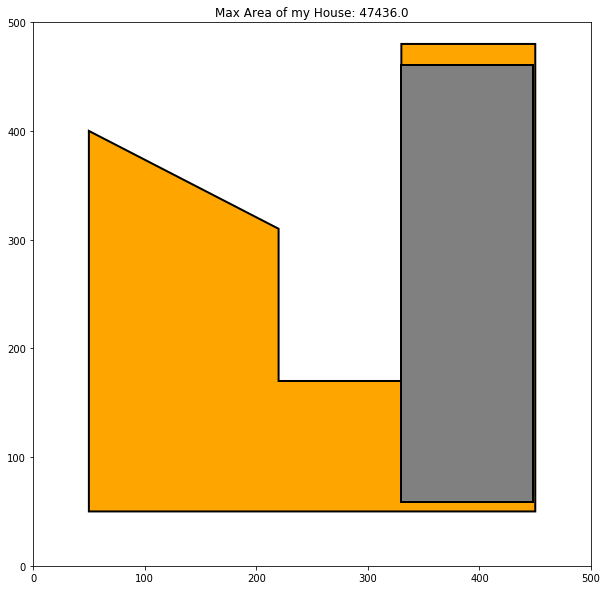

In [0]:
# Visualization Best plot
fig = plt.figure(figsize=(10,10))
canv = fig.add_subplot(1,1,1)
canv.set_xlim(0,500)
canv.set_ylim(0,500)
draw(polygonfig, poly2list(top['Best Coordinate'].iloc[0]))

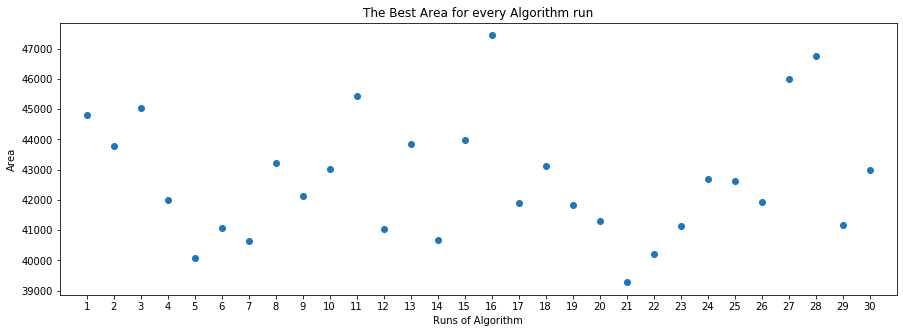

In [0]:
plt.figure(figsize=(15,5))
plt.xlim(0,31)
plt.xticks(np.arange(1,31,1))
plt.title('The Best Area for every Algorithm run')
plt.xlabel('Runs of Algorithm')
plt.ylabel('Area')
plt.scatter(linspace(1,30,num=30), final['Best Area'])

In [0]:
Nb_Runs = np.arange(1, 31, 1)
#xi = list(range(len(Nb_Runs)))
maxi = area(polygon)
maxi

67323.84

In [0]:
from statistics import *
print('Best of Best')
print('Mean is : {}'.format(round(mean(best_areas),2)))
print('Standard deviation : {} '.format(round(stdev(best_areas),2)))

Best of Best
Mean is : 42702.22
Standard deviation : 2033.43 


In [0]:
accuracy = [round(((e*100)/topa),1) for e in best_areas]
print(accuracy)

[94.5, 92.3, 94.9, 88.5, 84.5, 86.6, 85.7, 91.1, 88.8, 90.7, 95.8, 86.5, 92.4, 85.7, 92.7, 100.0, 88.4, 90.9, 88.2, 87.1, 82.8, 84.7, 86.7, 90.0, 89.9, 88.4, 96.9, 98.6, 86.8, 90.6]


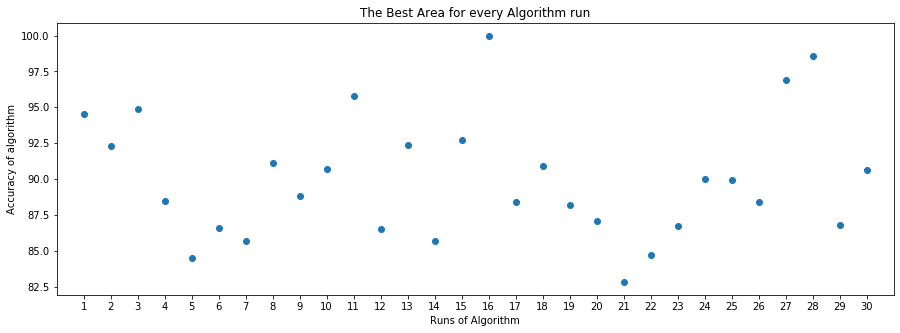

In [0]:
plt.figure(figsize=(15,5))
plt.xlim(0,31)
plt.xticks(np.arange(min(Nb_Runs), max(Nb_Runs)+1, 1.0))
plt.title('The Best Area for every Algorithm run')
plt.xlabel('Runs of Algorithm')
plt.ylabel('Accuracy of algorithm')
plt.scatter(Nb_Runs,accuracy)
plt.show()

In [0]:
# Mean Accuracy
print('Models Accuracy : {}'.format(mean(accuracy)))

Models Accuracy : 90.02333333333334


### Comparison

In [0]:
plt.boxplot(transpose(accuracy),notch=False, conf_intervals= None,whis=0.25)

In [0]:
x1 = [88.0, 91.6, 96.9, 95.6, 94.2, 95.8, 90.6, 88.0, 95.3, 87.6, 88.7, 92.5, 96.1, 88.8, 83.6, 96.9, 92.2, 90.1, 93.2, 100.0, 86.9, 84.8, 96.8, 89.8, 91.0, 86.2, 88.3, 87.6, 95.0, 89.6]
x2 = [96.9, 95.4, 95.1, 99.0, 76.2, 89.1, 99.2, 100.0, 98.7, 100.0, 99.7, 72.5, 83.2, 98.5, 94.1, 96.7, 100.0, 99.5, 97.5, 99.2, 92.9, 94.4, 80.9, 90.0, 96.4, 86.9, 100.0, 84.1, 100.0, 95.1]

In [0]:
deg = pd.DataFrame(data=[x1,x2])

In [0]:
plt.boxplot(deg,labels=['Tabu Search', 'PSO'])